In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_preexisting_field_ephys'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'

In [229]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [214]:
trial_index_to_index_within_df_all=prepped_data_agg['trial_index_to_index_within_df_all']

# extend place fields

In [11]:
subdb

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m2     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_26m1    3  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m1     2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_16f1    8  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e16_3m1     1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e13_16f1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_10m1    5  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
            6  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e13_16f1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_9f1     4  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e14_2m2     2  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e13_16f1    5  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            6  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e15_10m1    3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e14_2m2     1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e16_1f1     9  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            5  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e15_9f1     3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e14_2m3     5  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e16_1f1     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     7  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            6  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
e15_9f1     5  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e16_1f1     6  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e15_9f1     2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e16_2m1     2  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e15_10m1    4  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10...   
e15_9f1     0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f...   
e14_2m3     3  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
            2   e16_3m2_211212       e16_3m2  2021-12-12   
e16_3m1     3   e16_3m1_210203       e16_3m1  2021-02-03   
e16_3m

In [7]:
ani,sess = 'e15_13f1','e15_13f1_220117'
ti,tt = 0,0
if tt=='both':
    tt_rm = 0
else:
    tt_rm=tt
per_field_metrics_one = per_field_metrics_all.loc[ani,sess,ti,tt]
fr_map_trial_df_one = fr_map_trial_df_all.loc[ani,sess,ti,tt_rm]
all_fields_one = all_fields_recombined_all.loc[ani,sess,ti,tt]

/tmp/ipykernel_303943/3769244241.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[ani,sess,ti,tt]
/tmp/ipykernel_303943/3769244241.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_one = fr_map_trial_df_all.loc[ani,sess,ti,tt_rm]
/tmp/ipykernel_303943/3769244241.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_one = all_fields_recombined_all.loc[ani,sess,ti,tt]


In [8]:
ii=0
uid,field_id = per_field_metrics_one.query('si>0.5').index[ii]

/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


(<Figure size 216x144 with 2 Axes>, <Axes: xlabel='Position'>)

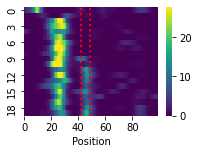

In [24]:
frmap=fr_map_trial_df_one.loc[uid].dropna(axis=1).T
field_bound=all_fields_one.loc[uid,field_id][['start','end']]
ph.ratemap_one_raw(frmap,field_bound=field_bound)

# extend field 

In [126]:
val_win_extended

,,,start,end,com,peak,fr_peak,fr_mean,other_field_index,window_start,window_end
level_0,level_1,field_index,,,,,,,,,
both,195,0,5,10,7,7,8.85698,8.09841,0.0,0,17
1.0,195,1,67,75,71,72,6.885493,6.120152,NaN,60,75


In [7]:

import place_field_detection_thomas as pfdt
reload(pfdt)

<module 'place_field_detection_thomas' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py'>

In [8]:
# get n pos per sess
gpb=fr_map_trial_df_all.groupby(level=(0,1,2))
npos_per_sess = {}
for k,val in gpb:
    npos = val.index.get_level_values(-1).unique().max()+1
    npos_per_sess[k] = npos
npos_per_sess=pd.Series(npos_per_sess)

In [40]:
# %%time
# gpb=all_fields_recombined_all.groupby(level=(0,1,2,4))
# all_fields_recombined_all_windowextended = []#{}
# i=0
# for k,val in gpb: # loop over cells

#     val = val.droplevel((0,1,2))
#     nfields_orig = val.shape[0]
#     npos = npos_per_sess.loc[k[:-1]]
#     val_win_extended_both = []
#     for tt in [0,1]: # over trialtypes, plus both
        
#         # the fields contain ones that occur in either both or tt 
#         if (tt in val.index.get_level_values(0)) and ('both' in val.index.get_level_values(0)):
#             val_onett_and_both=val.loc[(['both',tt]),:]
#         elif (tt in val.index.get_level_values(0)) and ('both' not in val.index.get_level_values(0)):
#             val_onett_and_both=val.loc[([tt]),:]
#         elif (tt not in val.index.get_level_values(0)) and ('both' in val.index.get_level_values(0)):
#             val_onett_and_both=val.loc[(['both']),:]
#         else:
#             val_onett_and_both=None
#         if val_onett_and_both is not None: # extend fields

#             val_reset=val_onett_and_both.sort_values('peak').reset_index()
#             val_win_extended=pfdt.get_window_outside(val_reset,npos=npos)
#             val_win_extended=val_win_extended.set_index(['level_0','level_1','field_index'])
#             val_win_extended_both.append(val_win_extended)

    
#     if len(val_win_extended_both) > 0: # if there's any field
#         val_win_extended_both_df = pd.concat(val_win_extended_both,axis=0) # combine the extended results for both trial types
#         # then need to trim the Both fields that are double counted
#         # for the Both fields, contract the windows obtained from excluding fields from 0 and 1 trialtypes
#         if 'both' in val_win_extended_both_df.index.get_level_values(0):
#             gpb_for_both=val_win_extended_both_df.loc[['both']].groupby(level='field_index') # group by field index for the both fields
#             remaining_both = [] 
#             for _,valval in gpb_for_both: # for each both fields, select the max of the start and min of the end
#                 row=valval.iloc[0]
#                 row['window_start']=valval['window_start'].max()
#                 row['window_end']=valval['window_end'].min()
#                 remaining_both.append(row.to_frame().T)
#             remaining_both = pd.concat(remaining_both,axis=0)
#             # then put the both fields back together with the non both fields.
#             not_both_ma=val_win_extended_both_df.index.get_level_values(0)!='both' 
#             val_win_extended_both_df_processed = pd.concat([val_win_extended_both_df.loc[not_both_ma],remaining_both],axis=0)
#         else: # if no both fields, don't have to do the contraction and reselection
#             val_win_extended_both_df_processed = val_win_extended_both_df
    
#     nfields_after = val_win_extended_both_df_processed.shape[0]
#     if nfields_after!=nfields_orig:
#         break
        
#     # update the index
#     current_index = val_win_extended_both_df_processed.index
#     new_tuples = [k[:3] + idx for idx in current_index]
#     new_index = pd.MultiIndex.from_tuples(new_tuples)
#     val_win_extended_both_df_processed.index = new_index
# #     all_fields_recombined_all_windowextended[k[:3]] = val_win_extended_both_df_processed

#     all_fields_recombined_all_windowextended.append(val_win_extended_both_df_processed)
    
# all_fields_recombined_all_windowextended = pd.concat(all_fields_recombined_all_windowextended,axis=0)



<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed e

CPU times: user 54.2 s, sys: 631 ms, total: 54.9 s
Wall time: 54.3 s


In [9]:
import pre_existing_field_analysis as pefa
reload(pefa)

<module 'pre_existing_field_analysis' from '/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py'>

#### skip if loading

In [47]:
%%time
all_fields_recombined_all_windowextended = pefa.extend_field_range_all(all_fields_recombined_all,fr_map_trial_df_all)



/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].max()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].min()
/mnt/home/szheng/projects/place_variability/code/pre_existing_field_analysis.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

CPU times: user 53.9 s, sys: 732 ms, total: 54.6 s
Wall time: 54 s


In [68]:
all_fields_all = prepped_data_agg['all_fields_all']

In [69]:
all_fields_all_windowextended = pefa.extend_field_range_all(all_fields_all,fr_map_trial_df_all)



In [50]:
# data_fn = 'all_fields_recombined_all_windowextended'
# data_fn_full = os.path.join(data_dir,data_fn)
# pickle.dump(all_fields_recombined_all_windowextended,open(data_fn_full,'wb'))



# find switching neurons that are below place field detection threshold 

In [10]:
import pf_one_session as pfos 

In [21]:
i=5
# ddf = subdb['data_dir_full'][i]
ddf = '/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/'
pf_res_old=pfos.main(ddf,dosave=False,force_reload=False,load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/place_field_afterheadscan.p exists; loading---


In [22]:
pf_res_old.keys()

dict_keys(['params', 'all_fields', 'sig_thresh_map'])

In [24]:
import tqdm

##### skip if loading

In [54]:
%%time
failed_l = []
sig_thresh_map_all = []
sig_thresh_map_all = {}
for _,row in tqdm.tqdm(subdb.iterrows()):
    ddf=row['data_dir_full']
    ani=row.name[0]
    sess = row['sess_name']
    
    try:
#         pf_res=pfos.main(ddf,dosave=True,force_reload=True,load_only=False,shuffle_force_reload=False)
        pf_res=pfos.main(ddf,dosave=False,force_reload=False,load_only=False,shuffle_force_reload=False)
        sig_thresh_map = pd.concat(pf_res['sig_thresh_map'],axis=0)
        sig_thresh_map_all[ani,sess] = sig_thresh_map
    except:
        failed_l.append(ddf)
sig_thresh_map_all = pd.concat(sig_thresh_map_all,axis=0)

8it [00:00, 73.84it/s]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/

34it [00:00, 83.23it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m1/e16_3m1_210119/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_

46it [00:00, 82.43it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200918/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200919/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200802/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f1/e16_1f1_200923/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200720/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201121/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m

In [71]:
# skip if loading
to_save = {'all_fields_recombined_all_windowextended':all_fields_recombined_all_windowextended,
           'all_fields_all_windowextended':all_fields_all_windowextended,
           'sig_thresh_map_all':sig_thresh_map_all,
          }
data_fn = os.path.join(data_dir,'data_for_pre_existing_field_analysis.p')
pickle.dump(to_save,open(data_fn,'wb'))



# load all_fields window extended 

In [89]:
data_fn = os.path.join(data_dir,'data_for_pre_existing_field_analysis.p')
res=pickle.load(open(data_fn,'rb'))
all_fields_recombined_all_windowextended = res['all_fields_recombined_all_windowextended']
sig_thresh_map_all = res['sig_thresh_map_all']
all_fields_all_windowextended = res['all_fields_all_windowextended']


In [90]:
# get the mean threshold within the field 
def get_mean_threshold_within_field(all_fields_recombined_all_windowextended,sig_thresh_map_all):
    thresh_all = {}
    for k,row in all_fields_recombined_all_windowextended.iterrows():
        ani,sess,ti,tt,uid = k[:5]
        if tt=='both':
            tt = 0
        st=row['start']
        ed=row['end']
        thresh_per_field = sig_thresh_map_all.loc[(ani,sess,ti,tt,uid),st:ed].mean()
        thresh_all[k] = thresh_per_field
    thresh_all = pd.Series(thresh_all)
    return thresh_all
    
%time thresh_all = get_mean_threshold_within_field(all_fields_recombined_all_windowextended,sig_thresh_map_all)     



CPU times: user 17.7 s, sys: 8.16 ms, total: 17.7 s
Wall time: 17.7 s


In [91]:
# get the mean outside of the field across trials
def get_mean_outside_field(all_fields_all_windowextended,fr_map_trial_df_all):
    mean_outside_field_all = {}
    for k,row in all_fields_all_windowextended.iterrows():
        ani,sess,ti,tt,uid = k[:5]
        st=row['start']
        ed=row['end']
        win_st = row['window_start']
        win_ed = row['window_end']
        
        sub1=fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].loc[win_st:st]
        sub2=fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].loc[ed:win_ed]
        
        npos = sub1.shape[0] + sub2.shape[1]
        mean_outside=(sub1.sum(axis=0,skipna=False) + sub2.sum(axis=0,skipna=False)) / npos
        
        mean_outside_field_all[k] = mean_outside
    mean_outside_field_all = pd.concat(mean_outside_field_all).unstack(level=-1)
        
    return mean_outside_field_all


In [14]:
# %time thresh_all = get_mean_threshold_within_field(all_fields_all_windowextended,sig_thresh_map_all)     
# %time thresh_all = get_mean_threshold_within_field(all_fields_recombined_all_windowextended,sig_thresh_map_all)     

CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 19.2 s


In [41]:
trial_index_to_index_within_df_all = prepped_data_agg['trial_index_to_index_within_df_all']

In [45]:
index_within_to_trial_index_all = trial_index_to_index_within_df_all.reset_index('trial_ind').set_index('index',append=True)

In [225]:
fr_map_res = fmos.main(ddf,force_reload=False,load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/fr_map_with_int.p exists; loading---


In [228]:
fr_map_res['fr_map_trial_df_pyr_combined']

0         1         2         3         4         5   \
0 0.0  1   0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                 ...       ...       ...       ...       ...       ...   
  both 135 94  0.001761  0.472671  2.424474  0.445884  3.317771  0.830644   
           95  0.000348  0.896851  3.614643  0.234814  3.007435  0.884156   
           96  0.000000  1.421538  4.639393  0.112307  2.802905  0.844016   
           97  0.000000  1.898499  5.351573  0.052920  2.683097  0.705486   
           98  0.000000  2.181392  5.709031  0.029903  2.626454  0.572650   

                     6         7    8         9   ...        12   13  \
0 0.0  1   0   0.000000  0.000000  0.0  0.000000  ...  0.000000  0.0   
           1   0.000000  0.000000  0.0  0.000000  ...  0.000000  0.0   
           2   0.000000  0.000000  0.0  0.000000  ...  0.000000  0.0   
           3   0.000000  0.000000  0.0  0.000000  ...  0.000000  0.0   
           4   0.000000  0.000000  0.0  0.000000  ...  0.000000  0.0   
...                 ...       ...  ...       ...  ...       ...  ...   
  both 135 94  5.982774  1.171389  0.0  0.642513  ...  0.806942  0.0   
           95  5.816419  1.052314  0.0  0.889029  ...  0.952116  0.0   
           96  5.186679  0.765760  0.0  1.254792  ...  1.109107  0.0   
           97  4.333533  0.501075  0.0  1.671824  ...  1.221726  0.0   
           98  3.678563  0.357347  0.0  1.962899  ...  1.275292  0.0   

                     14   15   16        17        18        19   20   21  
0 0.0  1   0   0.936212  NaN  NaN       NaN       NaN       NaN  NaN  NaN  
           1   0.888658  NaN  NaN       NaN       NaN       NaN  NaN  NaN  
           2   0.779214  NaN  NaN       NaN       NaN       NaN  NaN  NaN  
           3   0.599964  NaN  NaN       NaN       NaN       NaN  NaN  NaN  
           4   0.384358  NaN  NaN       NaN       NaN       NaN  NaN  NaN  
...                 ...  ...  ...       ...       ...       ...  ...  ...  
  both 135 94  1.046217  0.0  0.0  0.503837  0.020592  0.359843  0.0  0.0  
           95  0.996680  0.0  0.0  0.233289  0.004299  0.816093  0.0  0.0  
           96  0.913616  0.0  0.0  0.090524  0.000783  1.548421  0.0  0.0  
           97  0.825899  0.0  0.0  0.031853  0.000133  2.370977  0.0  0.0  
           98  0.771418  0.0  0.0  0.012749  0.000000  2.917198  0.0  0.0  

[33858 rows x 22 columns]

In [230]:
# skip if loading
# %time mean_outside_field_all = get_mean_outside_field(all_fields_all_windowextended,fr_map_trial_df_all)
%time mean_outside_field_all = get_mean_outside_field(all_fields_recombined_all_windowextended,fr_map_trial_df_pyr_combined_all)






/tmp/ipykernel_827592/4083371058.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub1=fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].loc[win_st:st]
/tmp/ipykernel_827592/4083371058.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub2=fr_map_trial_df_all.loc[(ani,sess,ti,tt,uid),:].loc[ed:win_ed]


CPU times: user 2min 37s, sys: 693 ms, total: 2min 38s
Wall time: 2min 38s


In [232]:
# skip if loading
to_save = {'all_fields_recombined_all_windowextended':all_fields_recombined_all_windowextended,
           'all_fields_all_windowextended':all_fields_all_windowextended,
           'sig_thresh_map_all':sig_thresh_map_all,
           'mean_outside_field_all':mean_outside_field_all
          }
data_fn = os.path.join(data_dir,'data_for_pre_existing_field_analysis.p')
pickle.dump(to_save,open(data_fn,'wb'))



In [17]:
data_fn = os.path.join(data_dir,'data_for_pre_existing_field_analysis.p')
res=pickle.load(open(data_fn,'rb'))
all_fields_recombined_all_windowextended = res['all_fields_recombined_all_windowextended']
sig_thresh_map_all = res['sig_thresh_map_all']
all_fields_all_windowextended = res['all_fields_all_windowextended']
mean_outside_field_all = res['mean_outside_field_all']

In [148]:
# one idea, keep the first switch of all fields; filter out fields whose pre switch mean fr is already above thresh
# then look at pre switch outside vs inside

In [18]:
all_sw_with_metrics_d_all_indset = all_sw_with_metrics_d_all.set_index(['trialtype','uid','field_index'],append=True)


In [19]:
# keep the first switch on and last switch off
gpb = all_sw_with_metrics_d_all_indset.groupby(level=(0,1,2,4,5,6))
first_on_last_off_all = []
for k,val in gpb:
    first_on_last_off = pd.concat([val.query('switch==1').iloc[:1],
               val.query('switch==-1').iloc[-1:]
              ],axis=0)
    first_on_last_off_all.append(first_on_last_off)

first_on_last_off_all = pd.concat(first_on_last_off_all,axis=0)

In [20]:
%%time
# get pre fr mean all
pre_mean_fr_all_frmean={}
post_mean_fr_all_frmean = {}
for k,row in first_on_last_off_all.iterrows():
    ani,sess,ti,_,tt,uid,field_id=k
    sw_tr_ind=row['trial_index']
    pre_frmean = pf_params_recombined_all.loc[ani,sess,'fr_mean',ti,tt,uid,field_id].loc[:(sw_tr_ind-1)].mean()
    pre_mean_fr_all_frmean[k] = pre_frmean
    post_frmean = pf_params_recombined_all.loc[ani,sess,'fr_mean',ti,tt,uid,field_id].loc[(sw_tr_ind):].mean()
    post_mean_fr_all_frmean[k] = post_frmean
pre_mean_fr_all_frmean = pd.Series(pre_mean_fr_all_frmean)
post_mean_fr_all_frmean = pd.Series(post_mean_fr_all_frmean)
#     pf_params_recombined_all

CPU times: user 1.77 s, sys: 11.8 ms, total: 1.79 s
Wall time: 1.78 s


In [21]:
# replace the metric subdf's pre mean fr all with the one calculated using fr mean instead of fr peak
first_on_last_off_all['pre_mean_fr_all'] = pre_mean_fr_all_frmean
first_on_last_off_all['post_mean_fr_all_frmean'] = post_mean_fr_all_frmean


In [26]:
# select fields whose pre mean fr below thresh, compare within and outisde

first_on_last_off_all['pre_below_thresh'] = first_on_last_off_all['pre_mean_fr_all'] < (thresh_all.loc[first_on_last_off_all.index.droplevel(3)].values)
first_on_last_off_all['post_below_thresh'] = first_on_last_off_all['post_mean_fr_all'] < (thresh_all.loc[first_on_last_off_all.index.droplevel(3)].values)




In [95]:
mean_within_field_all = pf_params_all.loc[(slice(None),slice(None),slice(None),slice(None),'fr_mean'),:].droplevel(-3)



In [216]:
first_on_last_off_all_onoff_ma

time  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       56  0            12083.149333   
                                     103 0            10096.595767   
                           1.0       71  1            10231.680000   
                                     86  0            12493.470033   
                                     88  2            10712.618567   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 0.0       205 0            13524.750633   
                           1.0       68  1            13767.229367   
                                     148 0            14723.524067   
                                     175 0            13423.541417   
                                     182 0            13621.358700   

                                                      speed_gauss  field_pos  \
                           trialtype uid field_index                           
e13_16f1 e13_16f1_210302 0 0.0       56  0               7.776674        0.0   
                                     103 0               3.325486        0.0   
                           1.0       71  1               6.263010       94.0   
                                     86  0               5.823295       34.0   
                                     88  2               3.101693       98.0   
...                                                           ...        ...   
e16_3m2  e16_3m2_211213  1 0.0       205 0               9.124596       10.0   
                           1.0       68  1              10.243087       24.0   
                                     148 0              16.034825       64.0   
                                     175 0               9.476359       56.0   
                                     182 0              18.576885       75.0   

                                                      trial_index  switch  \
                           trialtype uid field_index                        
e13_16f1 e13_16f1_210302 0 0.0       56  0                     14    -1.0   
                                     103 0                      4    -1.0   
                           1.0       71  1                      5    -1.0   
                                     86  0                     17    -1.0   
                                     88  2                      9    -1.0   
...                                                           ...     ...   
e16_3m2  e16_3m2_211213  1 0.0       205 0                      6    -1.0   
                           1.0       68  1                      9    -1.0   
                                     148 0                     20    -1.0   
                                     175 0                      3    -1.0   
                                     182 0                      7    -1.0   

                                                      index_within  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       56  0                       9   
                                     103 0                       2   
                           1.0       71  1                       2   
                                     86  0                       5   
                                     88  2                       3   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 0.0       205 0                       2   
                           1.0       68  1                       5   
                                     148 0                      10   
                                     175 0                       2   
                                     182 0                       4   

                                                      switch_trial  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       56  0               

In [233]:
%%time
# compute FR, aggregates, etc.; central field seperate

check_pre_or_post = {1:'pre',-1:'post'}

fr_within_outside_diff_all_onoff = {}
mean_fr_within_outside_diff_sw_all_onoff = {}

mean_within_field_all = pf_params_recombined_all.loc[(slice(None),slice(None),'fr_mean'),:].droplevel(2)
# mean_outside_field_all = 

for onoff in [1,-1]:
    first_on_last_off_all_onoff = first_on_last_off_all.query('switch==@onoff').droplevel(3)
    check_prefix=check_pre_or_post[onoff]
    check_key = f'{check_prefix}_below_thresh'
    ma = first_on_last_off_all_onoff[check_key]
    first_on_last_off_all_onoff_ma = first_on_last_off_all_onoff.loc[ma]
    n_sw = len(ma)
    n_below_thresh = ma.sum()
    frac = ma.mean()
    print(f'switch {onoff}, n field = {n_sw}, n_{check_key} = {n_below_thresh}, frac = {frac:.1f}')
    
    # get FR within, outside, diff, and mean pre and post
    ### output: use index within; WITH "Both" fields, trial combined
    fr_within_outside_diff_all = {}
    mean_fr_within_outside_diff_sw_all = {}
#     for tt_rm in [0,1]:
#         sub=first_on_last_off_all_onoff_ma.loc[(slice(None),slice(None),slice(None),[tt_rm,'both']),:]
#         for ind, row in sub.iterrows():
    for ind, row in first_on_last_off_all_onoff_ma.iterrows():
        ani,sess,ti,tt,uid,field_id=ind
        sw_trial_index = row['trial_index']
#             if tt_rm==1 and tt=='both':
#                 field_id = all_fields_recombined_all.loc[ani,sess,ti,tt,uid,field_id].loc['other_field_index']
        fr_within_outside_diff_one={}
        fr_within_outside_diff_one['within'] = mean_within_field_all.loc[ani,sess,ti,tt,uid,field_id]
        fr_within_outside_diff_one['outside'] = mean_outside_field_all.loc[ani,sess,ti,tt,uid,field_id]
        fr_within_outside_diff_one['diff'] =  fr_within_outside_diff_one['within'] - fr_within_outside_diff_one['outside']
        fr_within_outside_diff_one = pd.concat(fr_within_outside_diff_one,axis=1).T
        key = (ani,sess,ti,tt_rm,uid,field_id)
        fr_within_outside_diff_all[key] = fr_within_outside_diff_one



        mean_fr_within_outside_diff_sw = {}
        mean_fr_within_outside_diff_sw['pre'] = fr_within_outside_diff_one.loc[:,:(sw_trial_index-1)].mean(axis=1)
        mean_fr_within_outside_diff_sw['post'] = fr_within_outside_diff_one.loc[:,sw_trial_index:].mean(axis=1)

        mean_fr_within_outside_diff_sw = pd.DataFrame(mean_fr_within_outside_diff_sw)
        mean_fr_within_outside_diff_sw_all[key] = mean_fr_within_outside_diff_sw

    fr_within_outside_diff_all = pd.concat(fr_within_outside_diff_all,axis=0).unstack().swaplevel(0,1,axis=1)
    mean_fr_within_outside_diff_sw_all = pd.concat(mean_fr_within_outside_diff_sw_all,axis=0).unstack()
    
    fr_within_outside_diff_all_onoff[onoff]= fr_within_outside_diff_all
    mean_fr_within_outside_diff_sw_all_onoff[onoff]= mean_fr_within_outside_diff_sw_all
    
fr_within_outside_diff_all_onoff = pd.concat(fr_within_outside_diff_all_onoff,axis=0)
mean_fr_within_outside_diff_sw_all_onoff = pd.concat(mean_fr_within_outside_diff_sw_all_onoff,axis=0)

switch 1, n field = 2266, n_pre_below_thresh = 1452, frac = 0.6
switch -1, n field = 1483, n_post_below_thresh = 288, frac = 0.2
CPU times: user 2.6 s, sys: 11.8 ms, total: 2.61 s
Wall time: 2.61 s


In [96]:
# %%time
# # compute FR, aggregates, etc.

# check_pre_or_post = {1:'pre',-1:'post'}

# fr_within_outside_diff_all_onoff = {}
# mean_fr_within_outside_diff_sw_all_onoff = {}

# for onoff in [1,-1]:
#     first_on_last_off_all_onoff = first_on_last_off_all.query('switch==@onoff').droplevel(3)
#     check_prefix=check_pre_or_post[onoff]
#     check_key = f'{check_prefix}_below_thresh'
#     ma = first_on_last_off_all_onoff[check_key]
#     first_on_last_off_all_onoff_ma = first_on_last_off_all_onoff.loc[ma]
#     n_sw = len(ma)
#     n_below_thresh = ma.sum()
#     frac = ma.mean()
#     print(f'switch {onoff}, n field = {n_sw}, n_{check_key} = {n_below_thresh}, frac = {frac:.1f}')
    
#     # get FR within, outside, diff, and mean pre and post
#     ### output: use index within; no more "Both" fields, trial seperated
#     fr_within_outside_diff_all = {}
#     mean_fr_within_outside_diff_sw_all = {}
#     for tt_rm in [0,1]:
#         sub=first_on_last_off_all_onoff_ma.loc[(slice(None),slice(None),slice(None),[tt_rm,'both']),:]
#         for ind, row in sub.iterrows():
#             ani,sess,ti,tt,uid,field_id=ind
#             index_within = row['index_within']
#             if tt_rm==1 and tt=='both':
#                 field_id = all_fields_recombined_all.loc[ani,sess,ti,tt,uid,field_id].loc['other_field_index']
#             fr_within_outside_diff_one={}
#             fr_within_outside_diff_one['within'] = mean_within_field_all.loc[ani,sess,ti,tt_rm,uid,field_id]
#             fr_within_outside_diff_one['outside'] = mean_outside_field_all.loc[ani,sess,ti,tt_rm,uid,field_id]
#             fr_within_outside_diff_one['diff'] =  fr_within_outside_diff_one['within'] - fr_within_outside_diff_one['outside']
#             fr_within_outside_diff_one = pd.concat(fr_within_outside_diff_one,axis=1).T
#             key = (ani,sess,ti,tt_rm,uid,field_id)
#             fr_within_outside_diff_all[key] = fr_within_outside_diff_one



#             mean_fr_within_outside_diff_sw = {}
#             mean_fr_within_outside_diff_sw['pre'] = fr_within_outside_diff_one.loc[:,:(index_within-1)].mean(axis=1)
#             mean_fr_within_outside_diff_sw['post'] = fr_within_outside_diff_one.loc[:,index_within:].mean(axis=1)

#             mean_fr_within_outside_diff_sw = pd.DataFrame(mean_fr_within_outside_diff_sw)
#             mean_fr_within_outside_diff_sw_all[key] = mean_fr_within_outside_diff_sw

#     fr_within_outside_diff_all = pd.concat(fr_within_outside_diff_all,axis=0).unstack().swaplevel(0,1,axis=1)
#     mean_fr_within_outside_diff_sw_all = pd.concat(mean_fr_within_outside_diff_sw_all,axis=0).unstack()
    
#     fr_within_outside_diff_all_onoff[onoff]= fr_within_outside_diff_all
#     mean_fr_within_outside_diff_sw_all_onoff[onoff]= mean_fr_within_outside_diff_sw_all
    
# fr_within_outside_diff_all_onoff = pd.concat(fr_within_outside_diff_all_onoff,axis=0)
# mean_fr_within_outside_diff_sw_all_onoff = pd.concat(mean_fr_within_outside_diff_sw_all_onoff,axis=0)

switch 1, n field = 2266, n_pre_below_thresh = 1452, frac = 0.6
switch -1, n field = 1483, n_post_below_thresh = 288, frac = 0.2
CPU times: user 2.93 s, sys: 7.4 ms, total: 2.93 s
Wall time: 2.93 s


In [324]:
def get_pie_toplot(mean_fr_within_outside_diff_one):
    n_close_to_0 = np.isclose(mean_fr_within_outside_diff_one['within'],0).sum()

    not_close_0_ma=np.logical_not(np.isclose(mean_fr_within_outside_diff_one['within'],0))
    within_smaller_than_outside_ma= mean_fr_within_outside_diff_one['diff'] <= 0
    ma = within_smaller_than_outside_ma & not_close_0_ma

    n_not_close_and_within_smaller = ma.sum()

    within_larger_than_outside_ma= mean_fr_within_outside_diff_one['diff'] > 0
    ma = within_larger_than_outside_ma & not_close_0_ma
    n_not_close_and_within_higher = ma.sum()

    pie_toplot = {'no activity':n_close_to_0,
              'within higher':n_not_close_and_within_higher,
              'outside higher or equal':n_not_close_and_within_smaller
             }
    
    return pie_toplot

def plot_strip_box_and_pie(mean_fr_within_outside_diff_one,pie_toplot,figsize=(4,3),fig=None,axs=None):
    if axs is None:
        fig,axs=plt.subplots(1,2,figsize=figsize,gridspec_kw=dict(width_ratios=[0.5,1]))
        plt.subplots_adjust(wspace=0.1)
    ax=axs[0]
    sess_mean = mean_fr_within_outside_diff_one.groupby(level=(1,2,3)).mean()
    stat,pval=scipy.stats.wilcoxon(sess_mean['diff'])
    effect_size = sess_mean['diff'].mean() / sess_mean['diff'].std()
    ph.box_strip_plot(sess_mean,'within','outside',fig=fig,ax=ax)
    ax.set_ylabel('Mean FR (Hz)')
    ax.set_title(f'pval={pval:.01e}\neffect size={effect_size:.01f}')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

    ax=axs[1]
    patches, texts, autotexts=ax.pie(pie_toplot.values(),autopct='%1.0f%%',explode=[0.2,0.,0.2])
    for autotext in autotexts:
        autotext.set_color('white')  # Change color to white
    rotation_l = [0,90,0]
#     for text,rot in zip(texts,rotation_l):
#         text.set_rotation(rot)
    
    ax.set_title(f'n={mean_fr_within_outside_diff_one.shape[0]}')
    ax.set_aspect('equal')
    return fig,axs,patches,texts

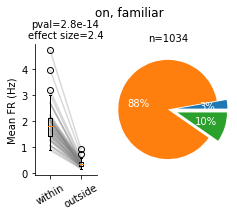

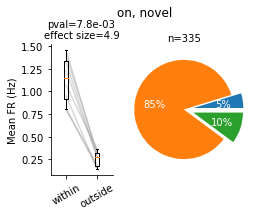

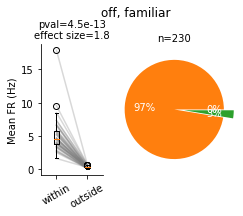

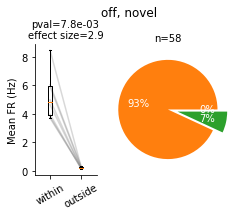

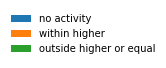

In [327]:
pre_post_d = {1:'pre',-1:'post'}
onoff_str_d = {1:'on',-1:'off'}
isnovel_str_d = {0:'familiar',1:'novel'}


for onoff,prep_post in pre_post_d.items():
    onoff_str = onoff_str_d[onoff]
    for isnovel in [0,1]:
        isnovel_str = isnovel_str_d[isnovel]
        mean_fr_within_outside_diff_one = mean_fr_within_outside_diff_sw_all_onoff.loc[(onoff,slice(None),slice(None),isnovel),pre_post]
        pie_toplot = get_pie_toplot(mean_fr_within_outside_diff_one)
        fig,axs,patches,texts= plot_strip_box_and_pie(mean_fr_within_outside_diff_one,pie_toplot,fig=None,axs=None,figsize=(3.5,2.4))
        supt=fig.suptitle(f'{onoff_str}, {isnovel_str}',y=1.1)
        
        figfn = f'mean_within_vs_outside_fr_boxstrip_pie_{onoff_str}_{isnovel_str}'
        ph.save_given_name(fig,figfn,figdir)

fig2, ax2 = plt.subplots(figsize=(1,1))
ax2.axis('off')  # Hide the axes

# Create the legend in the second figure
ax2.legend(patches, pie_toplot.keys(), loc='center',frameon=False) 
figfn = 'mean_within_vs_outside_fr_boxstrip_pie_legend'
ph.save_given_name(fig2,figfn,figdir)

        

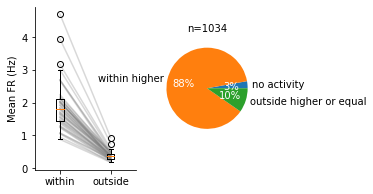

In [136]:
(mean_fr_within_outside_diff_one['diff']<0).mean()

0.07431340872374798

In [133]:
np.isclose(mean_fr_within_outside_diff_one['diff'],0).mean()

0.018578352180936994

<Axes: >

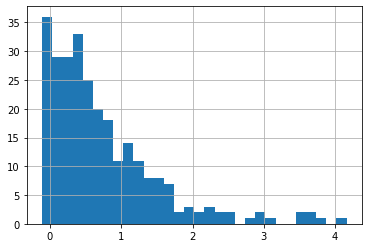

In [125]:
mean_fr_within_outside_diff_sw_all['post']['diff'].hist(bins=30)

<Axes: >

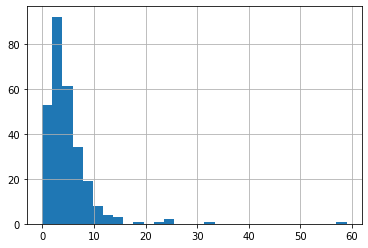

In [126]:
mean_fr_within_outside_diff_sw_all['pre']['diff'].hist(bins=30)

<Axes: >

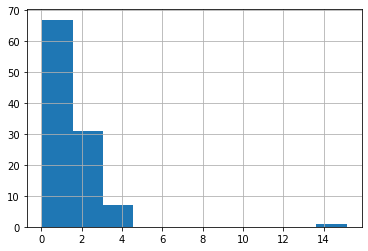

In [109]:
# session wise test

xx=mean_fr_within_outside_diff_sw_all['pre']['diff'].groupby(level=(0,1,2,3)).mean()
scipy.stats.wilcoxon(xx,alternative='greater')
xx.hist()

# demonstration

#### helper function

In [108]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
def plot_ratemap_and_avg(ind,fr_map_trial_df_all,all_fields_recombined_all_windowextended,
                         all_sw_with_metrics_d_all_indset,figsize=(1.5,2)
                        ):
    ani,sess,ti,tt,uid,field_id=ind
    
    fig=plt.figure(figsize=figsize)
    # gs = gridspec.GridSpec(2, 3, height_ratios=[0.2,0.5],width_ratios=[1,0.03,0.5])
    # gs = gridspec.GridSpec(2, 1, height_ratios=[0.2,0.5],hspace=0.2)
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.4,0.5],hspace=0.2)
    ax10=ax=fig.add_subplot(gs[1, 0])


    frmap=fr_map_trial_df_all.loc[ind[:-1]].dropna(axis=1).T
    row=all_fields_recombined_all_windowextended.loc[ani,sess,ti,tt,uid,field_id]
    field_bound=(row['start'],row['end'])
    sw_row=all_sw_with_metrics_d_all_indset.loc[(ani,sess,ti,slice(None),tt,uid,field_id)]
    ind_within=sw_row['index_within'].iloc[0]

    # fig,ax=ph.ratemap_one_raw(frmap,field_bound=field_bound,heatmap_kws=dict(vmax=8))
    fig,ax=ph.ratemap_one_raw(frmap,field_bound=field_bound,heatmap_kws=dict(cbar=False),trial=ind_within,ax=ax,fig=fig)
    window_bounds_one = (row['window_start'],row['window_end'])

    for win in window_bounds_one:
        ax.axvline(win,linestyle=':',color='orange')
    ax.set_ylabel('Trial')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3,integer=True))
    ax.set_yticklabels(ax.get_yticks().astype(int))


    ax00=ax=fig.add_subplot(gs[0, 0],sharex=ax10)
    frmap.loc[:(ind_within-1)].mean(axis=0).plot(ax=ax,c='blue',label='pre')
    frmap.loc[(ind_within):].mean(axis=0).plot(ax=ax,c='red',label='post')
    sig_thresh_map_all.loc[(ani,sess,ti,tt,uid),:].plot(ax=ax,linestyle=':',linewidth=1,label='threshold')
    sns.despine(ax=ax)
    # ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_xticks([])
    ax.set_title(ind)
    ax.set_ylabel('FR (Hz)')
    
    axs = np.array([ax00,ax10])
    
    return fig,axs

#### manual selection

In [396]:
# on example
ma=mean_fr_within_outside_diff_sw_all_onoff.loc[1,'pre']['diff'].loc[(slice(None),slice(None),[0])] > 0 # select within > outside, only familiar
inds=ma.index[ma]

hi_si_inds=per_field_metrics_all.query('si>1').index # high si

nfields_per_pc=all_fields_recombined_all.groupby(level=(0,1,2,3,4)).count().iloc[:,0]

one_field_inds=nfields_per_pc.loc[nfields_per_pc==1]

one_field_inds=nfields_per_pc.loc[nfields_per_pc==1]
one_field_inds=one_field_inds.to_frame()
one_field_inds['field_id'] = 0
one_field_inds=one_field_inds.set_index('field_id',append=True)
one_field_inds = one_field_inds.index   # single field

inds_sub=hi_si_inds.intersection(inds).intersection(one_field_inds) # only single field

In [458]:
ii=56
ind = inds_sub[ii]
print(ind)
ani,sess,ti,tt,uid,field_id=ind

('e13_26m1', 'e13_26m1_211019', 0, 0.0, 204, 0)


In [101]:
ind = ('e13_26m1', 'e13_26m1_211019', 0, 0.0, 204, 0)
ani,sess,ti,tt,uid,field_id = ind

/tmp/ipykernel_827592/2606763570.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap=fr_map_trial_df_all.loc[ind[:-1]].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_827592/2606763570.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int))


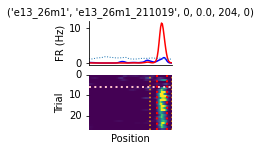

In [102]:
fig,axs = plot_ratemap_and_avg(ind,fr_map_trial_df_all,all_fields_recombined_all_windowextended,
                         all_sw_with_metrics_d_all_indset
                        )

In [465]:
# off example
ma=mean_fr_within_outside_diff_sw_all_onoff.loc[-1,'post']['diff'].loc[(slice(None),slice(None),[0])] > 0 # select within > outside, only familiar
inds=ma.index[ma]

hi_si_inds=per_field_metrics_all.query('si>1').index # high si

nfields_per_pc=all_fields_recombined_all.groupby(level=(0,1,2,3,4)).count().iloc[:,0]

one_field_inds=nfields_per_pc.loc[nfields_per_pc==1]

one_field_inds=nfields_per_pc.loc[nfields_per_pc==1]
one_field_inds=one_field_inds.to_frame()
one_field_inds['field_id'] = 0
one_field_inds=one_field_inds.set_index('field_id',append=True)
one_field_inds = one_field_inds.index   # single field

inds_sub=hi_si_inds.intersection(inds).intersection(one_field_inds) # only single field

In [472]:
ii=1
ind = inds_sub[ii]
print(ind)
ani,sess,ti,tt,uid,field_id=ind

('e13_26m1', 'e13_26m1_210913', 0, 0.0, 455, 0)


In [ ]:
ind = ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 455, 0)
ani,sess,ti,tt,uid,field_id = ind

/tmp/ipykernel_587084/1219559418.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap=fr_map_trial_df_all.loc[ind[:-1]].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_587084/1219559418.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int))


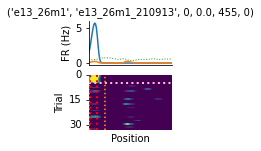

In [473]:
fig,axs = plot_ratemap_and_avg(ind,fr_map_trial_df_all,all_fields_recombined_all_windowextended,
                         all_sw_with_metrics_d_all_indset
                        )

#### actual plotting

/tmp/ipykernel_827592/4031097442.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap=fr_map_trial_df_all.loc[ind[:-1]].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:575: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)
/tmp/ipykernel_827592/4031097442.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int))


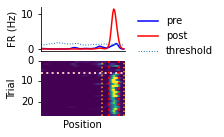

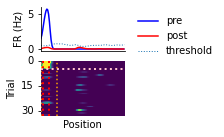

In [116]:
## plot together
ind_onoff = {}
ind = ('e13_26m1', 'e13_26m1_211019', 0, 0.0, 204, 0)
ind_onoff['on'] = ind


ind = ('e13_26m1', 'e13_26m1_210913', 0, 0.0, 455, 0)
ind_onoff['off']=ind

for k,ind in ind_onoff.items():
    ani,sess,ti,tt,uid,field_id = ind
    
    fig,axs = plot_ratemap_and_avg(ind,fr_map_trial_df_all,all_fields_recombined_all_windowextended,
                         all_sw_with_metrics_d_all_indset,figsize=(1.5,2)
                        )
    axs[0].set_title('')
    axs[0].legend(frameon=False,bbox_to_anchor=[1.05,1])
    figfn = f'ex_{k}_{ind}'
    ph.save_given_name(fig,figfn,figdir)

In [128]:
thresh_all

e13_16f1  e13_16f1_210302  0  0.0  7    1    5.015370
                                        3    4.340342
                                        4    4.991006
                              1.0  7    0    4.648949
                                        3    5.268149
                                               ...   
e16_3m2   e16_3m2_211213   1  0.0  205  2    1.427752
                                   206  0    3.069032
                              1.0  206  0    1.409757
                              0.0  207  0    1.171257
                              1.0  207  0    2.879446
Length: 14438, dtype: float64

In [117]:
all_fields_all_windowextended

start end com peak    fr_peak   fr_mean  \
e13_16f1 e13_16f1_210302 0 0.0 7   1     9  16  12   12   5.641149  5.400043   
                                   2    23  30  26   27   7.902512  6.458625   
                                   3    51  73  62   67   9.575179  7.888934   
                                   4    80  84  82   82   6.035547  5.771098   
                           1.0 7   0     0   4   1    0   9.707606  7.668994   
...                                    ...  ..  ..  ...        ...       ...   
e16_3m2  e16_3m2_211213  1 0.0 205 2    68  76  72   73   2.664258  2.263694   
                               206 0    26  42  34   34  15.026368  9.911881   
                           1.0 206 0    55  66  60   58   1.776016  1.637016   
                           0.0 207 0    65  70  67   67   2.179274  1.864303   
                           1.0 207 0    41  51  46   46   7.043599  5.504173   

                                     window_start window_end  
e13_16f1 e13_16f1_210302 0 0.0 7   1            0         23  
                                   2           16         39  
                                   3           42         80  
                                   4           73         93  
                           1.0 7   0            0         13  
...                                           ...        ...  
e16_3m2  e16_3m2_211213  1 0.0 205 2           61         75  
                               206 0           19         49  
                           1.0 206 0           48         73  
                           0.0 207 0           58         75  
                           1.0 207 0           34         58  

[15719 rows x 8 columns]

In [93]:
fr_within_outside_diff_all

0         1         2   \
e13_16f1 e13_16f1_210302 0 0 9   3 within   0.171350  4.618945  5.980590   
                                   outside  0.235291  0.964031  0.708537   
                                   diff    -0.063941  3.654914  5.272052   
                             11  0 within   1.101996  4.390385  2.709231   
                                   outside  0.444962  0.753976  1.028200   
...                                              ...       ...       ...   
e16_3m2  e16_3m2_211213  1 1 144 0 outside  0.315511  0.611691  0.053038   
                                   diff     1.628622  1.345466  0.074181   
                             192 0 within   0.237335  2.729586  0.000000   
                                   outside  0.715395  0.393637  0.000000   
                                   diff    -0.478060  2.335949  0.000000   

                                                  3         4         5   \
e13_16f1 e13_16f1_210302 0 0 9   3 within   3.084017  1.846496  7.428371   
                                   outside  0.526052  0.433959  0.680031   
                                   diff     2.557965  1.412538  6.748340   
                             11  0 within   5.437530  5.701942  5.526002   
                                   outside  1.210949  1.179700  1.041812   
...                                              ...       ...       ...   
e16_3m2  e16_3m2_211213  1 1 144 0 outside  0.029925  0.000000  0.000000   
                                   diff     0.256973  0.000000  0.000000   
                             192 0 within   0.215638  0.052598  2.552895   
                                   outside  0.092231  0.060309  0.120645   
                                   diff     0.123407 -0.007711  2.432250   

                                                  6          7          8   \
e13_16f1 e13_16f1_210302 0 0 9   3 within   7.504608  10.045681  10.803381   
                                   outside  0.508558   0.598211   0.714079   
                                   diff     6.996050   9.447471  10.089303   
                             11  0 within   4.828098   5.127861   9.223546   
                                   outside  1.254878   1.490063   1.528691   
...                                              ...        ...        ...   
e16_3m2  e16_3m2_211213  1 1 144 0 outside  0.391051   0.328173   0.216293   
                                   diff     4.399830   4.858763   5.686503   
                             192 0 within   6.220278   2.673231   1.263209   
                                   outside  0.291893   0.114069   0.069926   
                                   diff     5.928385   2.559163   1.193283   

                                                   9   ...  27  28  29  30  \
e13_16f1 e13_16f1_210302 0 0 9   3 within   11.682765  ... NaN NaN NaN NaN   
                                   outside   0.835952  ... NaN NaN NaN NaN   
                                   diff     10.846813  ... NaN NaN NaN NaN   
                             11  0 within   10.653777  ... NaN NaN NaN NaN   
                                   outside   1.275776  ... NaN NaN NaN NaN   
...                                               ...  ...  ..  ..  ..  ..   
e16_3m2  e16_3m2_211213  1 1 144 0 outside   0.092096  ... NaN NaN NaN NaN   
                                   diff      5.340603  ... NaN NaN NaN NaN   
                             192 0 within    1.241524  ... NaN NaN NaN NaN   
                                   outside   0.118361  ... NaN NaN NaN NaN   
                                   diff      1.123163  ... NaN NaN NaN NaN   

                                            31  32  33  34  35  36  
e13_16f1 e13_16f1_210302 0 0 9   3 within  NaN NaN NaN NaN NaN NaN  
                                   outside NaN NaN NaN NaN NaN NaN  
                                   diff    NaN NaN NaN NaN NaN NaN  
                             11  0 within  NaN NaN NaN NaN NaN NaN  
     

In [91]:
fr_within_outside_diff_one

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
within,0.237335,2.729586,0.0,0.215638,0.052598,2.552895,6.220278,2.673231,1.263209,1.241524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outside,0.715395,0.393637,0.0,0.092231,0.060309,0.120645,0.291893,0.114069,0.069926,0.118361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diff,-0.478060,2.335949,0.0,0.123407,-0.007711,2.432250,5.928385,2.559163,1.193283,1.123163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
row.index

Index(['time', 'speed_gauss', 'field_pos', 'trial_index', 'switch',
       'index_within', 'switch_trial', 'switch_trial_frac',
       'pre_ntrials_in_segment', 'post_ntrials_in_segment', 'pre_mean_fr_1',
       'pre_mean_fr_2', 'pre_mean_fr_3', 'pre_mean_fr_all', 'post_mean_fr_1',
       'post_mean_fr_2', 'post_mean_fr_3', 'post_mean_fr_all',
       'pre_mean_fr_1_norm', 'pre_mean_fr_2_norm', 'pre_mean_fr_3_norm',
       'pre_mean_fr_all_norm', 'post_mean_fr_1_norm', 'post_mean_fr_2_norm',
       'post_mean_fr_3_norm', 'post_mean_fr_all_norm', 'pre_ntrial_le_10_perc',
       'pre_ntrial_le_30_perc', 'pre_ntrial_le_50_perc',
       'pre_ntrial_le_70_perc', 'pre_ntrial_le_90_perc',
       'pre_ntrial_ge_10_perc', 'pre_ntrial_ge_30_perc',
       'pre_ntrial_ge_50_perc', 'pre_ntrial_ge_70_perc',
       'pre_ntrial_ge_90_perc', 'post_ntrial_le_10_perc',
       'post_ntrial_le_30_perc', 'post_ntrial_le_50_perc',
       'post_ntrial_le_70_perc', 'post_ntrial_le_90_perc',
       'post_ntrial_

In [78]:
diff

0    -0.478060
1     2.335949
2     0.000000
3     0.123407
4    -0.007711
5     2.432250
6     5.928385
7     2.559163
8     1.193283
9     1.123163
10    1.647122
11    2.368957
12    4.389893
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
Name: (e16_3m2, e16_3m2_211213, 1, 1.0, 192, 0), dtype: float64

In [63]:
first_on_last_off_all_onoff_ma

time  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3            10702.249283   
                                     11  0            11384.655600   
                                     25  3            10113.191642   
                                     32  1            10120.051700   
                                     33  0            11830.251900   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 both      26  0            14339.842550   
                                     36  0            15181.841367   
                                     74  0            13678.906767   
                                     144 0            13908.382133   
                                     192 0            13754.759500   

                                                      speed_gauss  field_pos  \
                           trialtype uid field_index                           
e13_16f1 e13_16f1_210302 0 0.0       9   3              10.825530       98.0   
                                     11  0               7.581448        9.0   
                                     25  3               2.194215       34.0   
                                     32  1               4.916643       39.0   
                                     33  0               6.574609       33.0   
...                                                           ...        ...   
e16_3m2  e16_3m2_211213  1 both      26  0               5.531209        0.0   
                                     36  0              17.390624        9.0   
                                     74  0               7.496533       23.0   
                                     144 0              18.525216        0.0   
                                     192 0              14.044780       15.0   

                                                      trial_index  switch  \
                           trialtype uid field_index                        
e13_16f1 e13_16f1_210302 0 0.0       9   3                      8     1.0   
                                     11  0                     12     1.0   
                                     25  3                      4     1.0   
                                     32  1                      4     1.0   
                                     33  0                     14     1.0   
...                                                           ...     ...   
e16_3m2  e16_3m2_211213  1 both      26  0                     16     1.0   
                                     36  0                     27     1.0   
                                     74  0                      8     1.0   
                                     144 0                     11     1.0   
                                     192 0                      9     1.0   

                                                      index_within  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3                       5   
                                     11  0                       8   
                                     25  3                       2   
                                     32  1                       2   
                                     33  0                       9   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 both      26  0                       7   
                                     36  0                      14   
                                     74  0                       3   
                                     144 0                       5   
                                     192 0                       5   

                                                      switch_trial  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3               

In [62]:
mean_within_field_all.loc[ani,sess,ti,tt_rm,uid,field_id]

0     0.001000
1     0.330728
2     0.399024
3     0.527049
4     5.144825
5     5.373127
6     5.353195
7     1.085236
8     4.114776
9     7.657709
10    2.586596
11    3.219298
12    3.355413
13    4.413947
14    5.268818
15    0.997551
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
Name: (e16_3m2, e16_3m2_211213, 1, 0.0, 192, 0), dtype: float64

In [ ]:
mean_outside_field_all

In [58]:
mean_within_field_all

0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.361854   1.660383   0.895757   
                               27 0  17.103153  14.839336  23.584129   
                               29 0   6.202601   7.169740  10.413588   
                                  1   9.346967   7.827861  16.289806   
                                  2   3.397194  16.512045  12.627846   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   2.346240   8.654606   3.477986   
                                  1   2.261897   3.072579   3.195431   
                               48 0  13.924181  14.022250  12.245751   
                               50 0   1.020293   1.978212   2.555436   
                               53 0   3.338543   0.011674   4.984835   

                                            3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.469980   0.000000   
                               27 0  21.687139  20.927104  17.838188   
                               29 0   8.762182   5.693805  13.419276   
                                  1  15.501734   6.856234  12.040284   
                                  2   7.590118   9.690987   6.867190   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.849853   2.409799   5.292874   
                                  1   7.909555   5.871727   5.904699   
                               48 0  10.816618  10.709636  14.932743   
                               50 0  11.942543   5.374571   9.256329   
                               53 0   0.000000   1.765900   6.571861   

                                            6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.000000   0.000000   
                               27 0  24.415946  19.023481  15.003316   
                               29 0   8.388599   8.172026   1.905900   
                                  1  10.954014  11.643840  12.378693   
                                  2   6.285377   3.561700   5.811030   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   4.721771   7.478724   9.907144   
                                  1   4.713215   3.891266   3.469568   
                               48 0  15.782163  14.870450  15.705794   
                               50 0   4.784752   3.493471   9.733499   
                               53 0   1.684778   1.970583   2.983026   

                                            9   ...         27         28  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.114686  ...   1.727335   2.000350   
                               27 0  18.116436  ...  18.481177  21.289542   
                               29 0   5.115633  ...   2.977193   1.106307   
                                  1  13.070182  ...  16.884102  11.851607   
                                  2  12.580423  ...  11.357698   5.928353   
...                                        ...  ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.805682  ...        NaN        NaN   
                                  1   7.165114  ...        NaN        NaN   
                               48 0  10.778764  ...        NaN        NaN   
                               50 0  10.105409  ...        NaN        NaN   
                               53 0   1.825949  ...        NaN        NaN   

                                            29         30         31  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.997584   1.732586   1.364074   
                               27 0  30.669419  19.191911  22.404392   
                               29 0   0.351097   4.521561   0.067966   
                                  1  15.579803  11.482377  12.537012   
                                  2   6.377334   7.828051   4.354688   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201

In [34]:
first_on_last_off_all_onoff_ma = first_on_last_off_all_onoff.loc[ma]

time  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3            10702.249283   
                                     11  0            11384.655600   
                                     25  3            10113.191642   
                                     32  1            10120.051700   
                                     33  0            11830.251900   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 both      26  0            14339.842550   
                                     36  0            15181.841367   
                                     74  0            13678.906767   
                                     144 0            13908.382133   
                                     192 0            13754.759500   

                                                      speed_gauss  field_pos  \
                           trialtype uid field_index                           
e13_16f1 e13_16f1_210302 0 0.0       9   3              10.825530       98.0   
                                     11  0               7.581448        9.0   
                                     25  3               2.194215       34.0   
                                     32  1               4.916643       39.0   
                                     33  0               6.574609       33.0   
...                                                           ...        ...   
e16_3m2  e16_3m2_211213  1 both      26  0               5.531209        0.0   
                                     36  0              17.390624        9.0   
                                     74  0               7.496533       23.0   
                                     144 0              18.525216        0.0   
                                     192 0              14.044780       15.0   

                                                      trial_index  switch  \
                           trialtype uid field_index                        
e13_16f1 e13_16f1_210302 0 0.0       9   3                      8     1.0   
                                     11  0                     12     1.0   
                                     25  3                      4     1.0   
                                     32  1                      4     1.0   
                                     33  0                     14     1.0   
...                                                           ...     ...   
e16_3m2  e16_3m2_211213  1 both      26  0                     16     1.0   
                                     36  0                     27     1.0   
                                     74  0                      8     1.0   
                                     144 0                     11     1.0   
                                     192 0                      9     1.0   

                                                      index_within  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3                       5   
                                     11  0                       8   
                                     25  3                       2   
                                     32  1                       2   
                                     33  0                       9   
...                                                            ...   
e16_3m2  e16_3m2_211213  1 both      26  0                       7   
                                     36  0                      14   
                                     74  0                       3   
                                     144 0                       5   
                                     192 0                       5   

                                                      switch_trial  \
                           trialtype uid field_index                 
e13_16f1 e13_16f1_210302 0 0.0       9   3               

In [32]:
mean_within_field_all.loc

0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.361854   1.660383   0.895757   
                               27 0  17.103153  14.839336  23.584129   
                               29 0   6.202601   7.169740  10.413588   
                                  1   9.346967   7.827861  16.289806   
                                  2   3.397194  16.512045  12.627846   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   2.346240   8.654606   3.477986   
                                  1   2.261897   3.072579   3.195431   
                               48 0  13.924181  14.022250  12.245751   
                               50 0   1.020293   1.978212   2.555436   
                               53 0   3.338543   0.011674   4.984835   

                                            3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.469980   0.000000   
                               27 0  21.687139  20.927104  17.838188   
                               29 0   8.762182   5.693805  13.419276   
                                  1  15.501734   6.856234  12.040284   
                                  2   7.590118   9.690987   6.867190   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.849853   2.409799   5.292874   
                                  1   7.909555   5.871727   5.904699   
                               48 0  10.816618  10.709636  14.932743   
                               50 0  11.942543   5.374571   9.256329   
                               53 0   0.000000   1.765900   6.571861   

                                            6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.000000   0.000000   
                               27 0  24.415946  19.023481  15.003316   
                               29 0   8.388599   8.172026   1.905900   
                                  1  10.954014  11.643840  12.378693   
                                  2   6.285377   3.561700   5.811030   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   4.721771   7.478724   9.907144   
                                  1   4.713215   3.891266   3.469568   
                               48 0  15.782163  14.870450  15.705794   
                               50 0   4.784752   3.493471   9.733499   
                               53 0   1.684778   1.970583   2.983026   

                                            9   ...         27         28  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.114686  ...   1.727335   2.000350   
                               27 0  18.116436  ...  18.481177  21.289542   
                               29 0   5.115633  ...   2.977193   1.106307   
                                  1  13.070182  ...  16.884102  11.851607   
                                  2  12.580423  ...  11.357698   5.928353   
...                                        ...  ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.805682  ...        NaN        NaN   
                                  1   7.165114  ...        NaN        NaN   
                               48 0  10.778764  ...        NaN        NaN   
                               50 0  10.105409  ...        NaN        NaN   
                               53 0   1.825949  ...        NaN        NaN   

                                            29         30         31  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.997584   1.732586   1.364074   
                               27 0  30.669419  19.191911  22.404392   
                               29 0   0.351097   4.521561   0.067966   
                                  1  15.579803  11.482377  12.537012   
                                  2   6.377334   7.828051   4.354688   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201

In [31]:
ma.index

MultiIndex([('e13_16f1', 'e13_16f1_210302', 0,    0.0,   9, 3),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  11, 0),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  13, 2),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  16, 1),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  22, 1),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  25, 3),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  27, 2),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  32, 1),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  33, 0),
            ('e13_16f1', 'e13_16f1_210302', 0,    0.0,  34, 2),
            ...
            ( 'e16_3m2',  'e16_3m2_211213', 1, 'both',  34, 0),
            ( 'e16_3m2',  'e16_3m2_211213', 1, 'both',  36, 0),
            ( 'e16_3m2',  'e16_3m2_211213', 1, 'both',  74, 0),
            ( 'e16_3m2',  'e16_3m2_211213', 1, 'both', 109, 0),
            ( 'e16_3m2',  'e16_3m2_211213', 1, 'both', 124, 0),
            ( 'e16_3m2',

In [28]:

mean_outside_field_all


In [157]:
val.query('switch==1').iloc[-1:]

,,,,,,,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment,...,post_ntrial_le_10_perc_frac_total,post_ntrial_le_30_perc_frac_total,post_ntrial_le_50_perc_frac_total,post_ntrial_le_70_perc_frac_total,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total
,,,,trialtype,uid,field_index,,,,,,,,,,,,,,,,,,,,,
e16_3m2,e16_3m2_211213,1,27,both,192,0,13754.7595,14.04478,15.0,9,1.0,5,9.0,0.310345,9,20,...,0.0,0.206897,0.448276,0.586207,0.655172,0.689655,0.482759,0.241379,0.103448,0.034483


In [145]:
all_sw_with_metrics_d_all['pre_mean_fr_all']

e13_26m1  e13_26m1_210913  0  0     11.557652
                              1      8.421709
                              2     12.097529
                              3     20.412759
                              4      2.225796
                                      ...    
e14_2m3   e14_2m3_201118   0  20     0.648804
                              21    17.055608
                              22     8.483471
                              23     5.069462
                              24     5.592148
Name: pre_mean_fr_all, Length: 4055, dtype: float64

<Axes: >

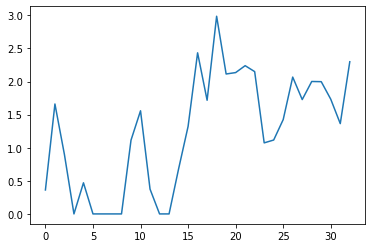

In [141]:
fr_mean_all_per_trial.loc[(ani,sess,ti,tt_rm,uid,field_id),:].plot()

In [128]:
(first_trial_all > 3)

e13_26m1  e13_26m1_210913  0  0.0  3   0    False
                                   27  0    False
                                   29  0    False
                                       1    False
                                       2    False
                                            ...  
e14_2m3   e14_2m3_201118   0  1.0  47  0    False
                                       1    False
                                   48  0    False
                                   50  0    False
                                   53  0    False
Length: 15717, dtype: bool

In [123]:
row.index[row]

0

In [120]:
row.nonzero()

AttributeError: 'Series' object has no attribute 'nonzero'

In [116]:
np.nonzero(row.values)[0]

array([], dtype=int64)

In [104]:
fr_mean_all_per_trial

0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.361854   1.660383   0.895757   
                               27 0  17.103153  14.839336  23.584129   
                               29 0   6.202601   7.169740  10.413588   
                                  1   9.346967   7.827861  16.289806   
                                  2   3.397194  16.512045  12.627846   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   2.346240   8.654606   3.477986   
                                  1   2.261897   3.072579   3.195431   
                               48 0  13.924181  14.022250  12.245751   
                               50 0   1.020293   1.978212   2.555436   
                               53 0   3.338543   0.011674   4.984835   

                                            3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.469980   0.000000   
                               27 0  21.687139  20.927104  17.838188   
                               29 0   8.762182   5.693805  13.419276   
                                  1  15.501734   6.856234  12.040284   
                                  2   7.590118   9.690987   6.867190   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.849853   2.409799   5.292874   
                                  1   7.909555   5.871727   5.904699   
                               48 0  10.816618  10.709636  14.932743   
                               50 0  11.942543   5.374571   9.256329   
                               53 0   0.000000   1.765900   6.571861   

                                            6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0 3  0   0.000000   0.000000   0.000000   
                               27 0  24.415946  19.023481  15.003316   
                               29 0   8.388599   8.172026   1.905900   
                                  1  10.954014  11.643840  12.378693   
                                  2   6.285377   3.561700   5.811030   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   4.721771   7.478724   9.907144   
                                  1   4.713215   3.891266   3.469568   
                               48 0  15.782163  14.870450  15.705794   
                               50 0   4.784752   3.493471   9.733499   
                               53 0   1.684778   1.970583   2.983026   

                                            9   ...         27         28  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.114686  ...   1.727335   2.000350   
                               27 0  18.116436  ...  18.481177  21.289542   
                               29 0   5.115633  ...   2.977193   1.106307   
                                  1  13.070182  ...  16.884102  11.851607   
                                  2  12.580423  ...  11.357698   5.928353   
...                                        ...  ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 47 0   1.805682  ...        NaN        NaN   
                                  1   7.165114  ...        NaN        NaN   
                               48 0  10.778764  ...        NaN        NaN   
                               50 0  10.105409  ...        NaN        NaN   
                               53 0   1.825949  ...        NaN        NaN   

                                            29         30         31  \
e13_26m1 e13_26m1_210913 0 0.0 3  0   1.997584   1.732586   1.364074   
                               27 0  30.669419  19.191911  22.404392   
                               29 0   0.351097   4.521561   0.067966   
                                  1  15.579803  11.482377  12.537012   
                                  2   6.377334   7.828051   4.354688   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201

In [ ]:
fr_mean_all_per_trial > thresh_all.loc[fr_mean_all_per_trial.index].values[:,None]



In [ ]:
# find trials before and after threshold crossing for each field
def find_trial_of_threshold_crossing_all():
    

In [ ]:
# compare the inside-outside before the threshold crossing


In [ ]:
for

In [55]:
sig_thresh_map_all

lin_binned                                  0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.075026   0.067238   0.061875   
                               2.0    0.004028   0.005701   0.008247   
                               3.0    0.227303   0.212910   0.198701   
                               27.0  18.066591  17.955364  17.804825   
                               29.0   4.513818   4.405280   4.236357   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.710426  13.624263  13.498259   
                               50.0   2.219777   2.172254   2.079314   
                               52.0   0.235614   0.221203   0.195078   
                               53.0   2.062102   2.035642   1.978397   
                               54.0   0.527518   0.493991   0.466617   

lin_binned                                  3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.057534   0.053851   0.053189   
                               2.0    0.010653   0.012642   0.012724   
                               3.0    0.186678   0.191985   0.198233   
                               27.0  17.605126  17.555131  17.583519   
                               29.0   4.175907   4.143672   4.134500   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.320490  13.054418  13.032933   
                               50.0   2.009559   1.890180   1.971024   
                               52.0   0.206892   0.188544   0.193207   
                               53.0   1.929697   1.873802   1.888014   
                               54.0   0.439777   0.431563   0.449554   

lin_binned                                  6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.053966   0.056534   0.058217   
                               2.0    0.013945   0.013127   0.011395   
                               3.0    0.202465   0.206956   0.204404   
                               27.0  17.584545  17.605270  17.627771   
                               29.0   4.183059   4.259999   4.226835   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.338774  13.565899  13.786495   
                               50.0   2.062082   2.186007   2.235242   
                               52.0   0.198265   0.217226   0.224881   
                               53.0   1.895169   1.907428   1.931991   
                               54.0   0.462161   0.474590   0.476209   

lin_binned                                  9   ...         90         91  \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.062534  ...   0.074752   0.078509   
                               2.0    0.009237  ...   0.002115   0.000906   
                               3.0    0.209573  ...   0.255281   0.261869   
                               27.0  17.664656  ...  17.997173  18.293964   
                               29.0   4.309961  ...   4.841556   4.853739   
...                                        ...  ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.935943  ...  12.994893  13.047446   
                               50.0   2.239491  ...   1.903631   1.901140   
                               52.0   0.219164  ...   0.151572   0.156043   
                               53.0   1.958049  ...   1.716543   1.711707   
                               54.0   0.484273  ...   0.396524   0.396378   

lin_binned                                  92         93         94  \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.075495   0.074053   0.071014   
                               2.0    0.001117   0.002429   0.000813   
                               3.0    0.261476   0.255310   0.254530   
                               27.0  18.415696  18.570999  18.538410   
                               29.0   4.781197   4.709137   4.657875   
...                                        ...  

In [36]:
fr_map_trial_df_all

0         1         2   \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  0.000000   
                                    1   0.000000  0.000000  0.000000   
                                    2   0.000000  0.000000  0.000000   
                                    3   0.000000  0.000000  0.000000   
                                    4   0.000000  0.000000  0.000000   
...                                          ...       ...       ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.228908  0.107838  0.319165   
                                    95  0.437416  0.054944  0.273498   
                                    96  0.668342  0.025218  0.214291   
                                    97  0.845171  0.010261  0.152462   
                                    98  0.934170  0.004174  0.109505   

                                              3         4    5    6    7   \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  0.0  0.0  0.0   
                                    1   0.000000  0.000000  0.0  0.0  0.0   
                                    2   0.000000  0.000000  0.0  0.0  0.0   
                                    3   0.000000  0.000000  0.0  0.0  0.0   
                                    4   0.000000  0.000000  0.0  0.0  0.0   
...                                          ...       ...  ...  ...  ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.061053  0.000326  0.0  0.0  0.0   
                                    95  0.025358  0.000000  0.0  0.0  0.0   
                                    96  0.008699  0.000000  0.0  0.0  0.0   
                                    97  0.002511  0.000000  0.0  0.0  0.0   
                                    98  0.000763  0.000000  0.0  0.0  0.0   

                                              8         9   ...   27   28  \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.000000  0.000000  ...  0.0  0.0   
                                    1   0.000000  0.000000  ...  0.0  0.0   
                                    2   0.000000  0.000000  ...  0.0  0.0   
                                    3   0.000000  0.000000  ...  0.0  0.0   
                                    4   0.000000  0.000000  ...  0.0  0.0   
...                                          ...       ...  ...  ...  ...   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  0.210997  0.637280  ...  NaN  NaN   
                                    95  0.142821  0.533430  ...  NaN  NaN   
                                    96  0.082327  0.446984  ...  NaN  NaN   
                                    97  0.039830  0.391175  ...  NaN  NaN   
                                    98  0.019110  0.364898  ...  NaN  NaN   

                                         29   30   31        32  33  34  35  \
e13_26m1 e13_26m1_210913 0 0.0 1.0  0   0.0  0.0  0.0  1.388314 NaN NaN NaN   
                                    1   0.0  0.0  0.0  1.133691 NaN NaN NaN   
                                    2   0.0  0.0  0.0  0.824918 NaN NaN NaN   
                                    3   0.0  0.0  0.0  0.603731 NaN NaN NaN   
                                    4   0.0  0.0  0.0  0.482523 NaN NaN NaN   
...                                     ...  ...  ...       ...  ..  ..  ..   
e14_2m3  e14_2m3_201118  0 1.0 54.0 94  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    95  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    96  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    97  NaN  NaN  NaN       NaN NaN NaN NaN   
                                    98  NaN  NaN  NaN       NaN NaN NaN NaN   

                                        36  
e13_26m1 e13_26m1_210913 0 0.0 1.0  0  NaN  
                                    1  NaN  
                                    2  NaN  
                                    3  NaN  
                                    4  NaN  
...                                     ..  
e14_2m3  e14_2m3_201118  0 1.0 54.0 94 NaN  
                      

In [35]:
sig_thresh_map_all

lin_binned                                  0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.075026   0.067238   0.061875   
                               2.0    0.004028   0.005701   0.008247   
                               3.0    0.227303   0.212910   0.198701   
                               27.0  18.066591  17.955364  17.804825   
                               29.0   4.513818   4.405280   4.236357   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.710426  13.624263  13.498259   
                               50.0   2.219777   2.172254   2.079314   
                               52.0   0.235614   0.221203   0.195078   
                               53.0   2.062102   2.035642   1.978397   
                               54.0   0.527518   0.493991   0.466617   

lin_binned                                  3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.057534   0.053851   0.053189   
                               2.0    0.010653   0.012642   0.012724   
                               3.0    0.186678   0.191985   0.198233   
                               27.0  17.605126  17.555131  17.583519   
                               29.0   4.175907   4.143672   4.134500   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.320490  13.054418  13.032933   
                               50.0   2.009559   1.890180   1.971024   
                               52.0   0.206892   0.188544   0.193207   
                               53.0   1.929697   1.873802   1.888014   
                               54.0   0.439777   0.431563   0.449554   

lin_binned                                  6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.053966   0.056534   0.058217   
                               2.0    0.013945   0.013127   0.011395   
                               3.0    0.202465   0.206956   0.204404   
                               27.0  17.584545  17.605270  17.627771   
                               29.0   4.183059   4.259999   4.226835   
...                                        ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.338774  13.565899  13.786495   
                               50.0   2.062082   2.186007   2.235242   
                               52.0   0.198265   0.217226   0.224881   
                               53.0   1.895169   1.907428   1.931991   
                               54.0   0.462161   0.474590   0.476209   

lin_binned                                  9   ...         90         91  \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.062534  ...   0.074752   0.078509   
                               2.0    0.009237  ...   0.002115   0.000906   
                               3.0    0.209573  ...   0.255281   0.261869   
                               27.0  17.664656  ...  17.997173  18.293964   
                               29.0   4.309961  ...   4.841556   4.853739   
...                                        ...  ...        ...        ...   
e14_2m3  e14_2m3_201118  0 1.0 48.0  13.935943  ...  12.994893  13.047446   
                               50.0   2.239491  ...   1.903631   1.901140   
                               52.0   0.219164  ...   0.151572   0.156043   
                               53.0   1.958049  ...   1.716543   1.711707   
                               54.0   0.484273  ...   0.396524   0.396378   

lin_binned                                  92         93         94  \
e13_26m1 e13_26m1_210913 0 0.0 1.0    0.075495   0.074053   0.071014   
                               2.0    0.001117   0.002429   0.000813   
                               3.0    0.261476   0.255310   0.254530   
                               27.0  18.415696  18.570999  18.538410   
                               29.0   4.781197   4.709137   4.657875   
...                                        ...  

In [ ]:
fr

In [29]:
pd.concat(pf_res['sig_thresh_map'],axis=0)

lin_binned         0          1          2          3          4          5   \
0 0.0 2      4.881744   4.834455   4.835360   4.840826   4.811185   4.858216   
      3      4.889389   4.828564   4.707714   4.582449   4.546364   4.536057   
      4      1.658362   1.635439   1.598262   1.614148   1.667431   1.670767   
      5      3.365302   3.349119   3.321840   3.282339   3.285353   3.300016   
      6      6.927655   6.860344   6.846765   6.735533   6.891201   6.833030   
...               ...        ...        ...        ...        ...        ...   
  1.0 48    13.710426  13.624263  13.498259  13.320490  13.054418  13.032933   
      50     2.219777   2.172254   2.079314   2.009559   1.890180   1.971024   
      52     0.235614   0.221203   0.195078   0.206892   0.188544   0.193207   
      53     2.062102   2.035642   1.978397   1.929697   1.873802   1.888014   
      54     0.527518   0.493991   0.466617   0.439777   0.431563   0.449554   

lin_binned         6          7          8          9   ...         90  \
0 0.0 2      4.970541   5.013378   5.062164   5.148307  ...   4.243487   
      3      4.722929   4.879674   5.072513   5.136352  ...   3.902375   
      4      1.709053   1.741444   1.774452   1.786204  ...   1.218526   
      5      3.361985   3.419419   3.477746   3.516403  ...   2.977751   
      6      6.769901   6.817721   6.963686   6.870526  ...   5.643983   
...               ...        ...        ...        ...  ...        ...   
  1.0 48    13.338774  13.565899  13.786495  13.935943  ...  12.994893   
      50     2.062082   2.186007   2.235242   2.239491  ...   1.903631   
      52     0.198265   0.217226   0.224881   0.219164  ...   0.151572   
      53     1.895169   1.907428   1.931991   1.958049  ...   1.716543   
      54     0.462161   0.474590   0.476209   0.484273  ...   0.396524   

lin_binned         91         92         93         94         95         96  \
0 0.0 2      4.238283   4.214662   4.197349   4.228684   4.304191   4.400774   
      3      3.842952   3.907352   4.030872   4.114799   4.081439   4.085068   
      4      1.212070   1.223825   1.229309   1.257636   1.285100   1.314834   
      5      2.989242   3.003847   3.012540   3.014420   3.026520   3.051452   
      6      5.687303   5.695125   5.633916   5.677758   5.812394   5.973914   
...               ...        ...        ...        ...        ...        ...   
  1.0 48    13.047446  12.994144  12.914183  12.716404  12.480835  12.327587   
      50     1.901140   1.901251   1.888109   1.877971   1.820295   1.754557   
      52     0.156043   0.157257   0.155468   0.153226   0.143572   0.140260   
      53     1.711707   1.655628   1.620478   1.609470   1.575430   1.599628   
      54     0.396378   0.385424   0.384760   0.371314   0.354934   0.349766   

lin_binned         97         98         99  
0 0.0 2      4.517833   4.559948   4.589922  
      3      4.173825   4.302621   4.359672  
      4      1.423425   1.470548   1.503428  
      5      3.067377   3.120177   3.159341  
      6      6.047805   6.118566   6.172762  
...               ...        ...        ...  
  1.0 48    12.429133  12.537567  12.584087  
      50     1.797595   1.825857   1.844130  
      52     0.151599   0.161929   0.164384  
      53     1.660238   1.736515   1.769142  
      54     0.386255   0.404233   0.415178  

[78 rows x 100 columns]

In [61]:
pf_res.keys()

dict_keys(['params', 'all_fields', 'sig_thresh_map'])

In [43]:
all_fields_recombined_all

start end com peak    fr_peak  \
                                   field_index                                 
e13_26m1 e13_26m1_210913 0 0.0  3  0              24  40  32   32   2.327171   
                                27 0               0  30  15   15  27.438358   
                                29 0               2   9   5    6   5.685168   
                                   1              20  38  29   30   22.52481   
                                   2              69  85  77   78  13.938965   
...                                              ...  ..  ..  ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0               6  23  14   13   6.647433   
                                32 0               5  26  15   18   7.859794   
                                38 0               0   7   2    0   5.592037   
                                47 0               4  10   7    7    3.72037   
                                53 0               0   6   2    4   2.114954   

                                                  fr_mean  other_field_index  
                                   field_index                                
e13_26m1 e13_26m1_210913 0 0.0  3  0             1.246869                NaN  
                                27 0            21.794745                NaN  
                                29 0             5.262314                NaN  
                                   1            14.049665                NaN  
                                   2             9.956611                NaN  
...                                                   ...                ...  
e14_2m3  e14_2m3_201118  0 both 30 0             4.711355                0.0  
                                32 0             6.384746                0.0  
                                38 0             3.799054                0.0  
                                47 0             3.481984                0.0  
                                53 0             2.088343                0.0  

[14438 rows x 7 columns]

In [33]:
nfields_orig

3

In [30]:
all_fields_recombined_all

start end com peak    fr_peak  \
                                   field_index                                 
e13_26m1 e13_26m1_210913 0 0.0  3  0              24  40  32   32   2.327171   
                                27 0               0  30  15   15  27.438358   
                                29 0               2   9   5    6   5.685168   
                                   1              20  38  29   30   22.52481   
                                   2              69  85  77   78  13.938965   
...                                              ...  ..  ..  ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0               6  23  14   13   6.647433   
                                32 0               5  26  15   18   7.859794   
                                38 0               0   7   2    0   5.592037   
                                47 0               4  10   7    7    3.72037   
                                53 0               0   6   2    4   2.114954   

                                                  fr_mean  other_field_index  
                                   field_index                                
e13_26m1 e13_26m1_210913 0 0.0  3  0             1.246869                NaN  
                                27 0            21.794745                NaN  
                                29 0             5.262314                NaN  
                                   1            14.049665                NaN  
                                   2             9.956611                NaN  
...                                                   ...                ...  
e14_2m3  e14_2m3_201118  0 both 30 0             4.711355                0.0  
                                32 0             6.384746                0.0  
                                38 0             3.799054                0.0  
                                47 0             3.481984                0.0  
                                53 0             2.088343                0.0  

[14438 rows x 7 columns]

In [37]:
all_fields_recombined_all_windowextended

start end com peak    fr_peak    fr_mean  \
e13_16f1 e13_16f1_210302 0 0.0 7  1     9  16  12   12   5.641149   5.400043   
                                  3    51  73  62   67   9.575179   7.888934   
                                  4    80  84  82   82   6.035547   5.771098   
                           1.0 7  0     0   4   1    0   9.707606   7.668994   
                                  3    87  99  93   99  14.290411  11.636348   
...                                   ...  ..  ..  ...        ...        ...   
         e13_16f1_210312 0 0.0 62 0    31  39  34   34   8.018664   6.221917   
                                  1    86  99  92   92  14.654359   9.646306   
                           1.0 62 0    30  44  37   38   6.133592   4.080098   
                           0.0 63 0    59  68  63   63   4.777897   3.476867   
                           1.0 63 0    41  50  45   43   1.087121   0.881237   

                                    other_field_index window_start window_end  
e13_16f1 e13_16f1_210302 0 0.0 7  1               NaN            0         23  
                                  3               NaN           42         80  
                                  4               NaN           73         93  
                           1.0 7  0               NaN            0         13  
                                  3               NaN           78         98  
...                                               ...          ...        ...  
         e13_16f1_210312 0 0.0 62 0               NaN           22         48  
                                  1               NaN           77         98  
                           1.0 62 0               NaN           21         53  
                           0.0 63 0               NaN           50         77  
                           1.0 63 0               NaN           32         59  

[464 rows x 9 columns]

In [142]:
len(all_fields_recombined_all_windowextended.keys())

54

In [140]:
all_fields_recombined_all_windowextended

start end com peak  \
                           level_0 level_1 field_index                      
e13_16f1 e13_16f1_210302 0 0.0     135     0              29  33  30   31   
                                           1              53  71  62   62   
                           1.0     135     0              27  38  32   33   
                                           1              48  52  49   49   
         e13_16f1_210312 0 0.0     124     1              31  39  35   35   
...                                                      ...  ..  ..  ...   
e16_3m2  e16_3m2_211212  1 0.0     195     0              11  18  14   14   
         e16_3m2_211213  0 0.0     207     0              46  51  48   48   
                           1.0     207     0              69  83  76   77   
                         1 0.0     207     0              65  70  67   67   
                           1.0     207     0              41  51  46   46   

                                                         fr_peak   fr_mean  \
                           level_0 level_1 field_index                       
e13_16f1 e13_16f1_210302 0 0.0     135     0            2.042158  1.863619   
                                           1            2.958067  2.410605   
                           1.0     135     0            5.032298  4.067666   
                                           1            2.985493  2.718383   
         e13_16f1_210312 0 0.0     124     1            4.550872  4.014725   
...                                                          ...       ...   
e16_3m2  e16_3m2_211212  1 0.0     195     0            1.105357   1.00489   
         e16_3m2_211213  0 0.0     207     0            1.400435  1.232676   
                           1.0     207     0            5.462865   3.40354   
                         1 0.0     207     0            2.179274  1.864303   
                           1.0     207     0            7.043599  5.504173   

                                                       other_field_index  \
                           level_0 level_1 field_index                     
e13_16f1 e13_16f1_210302 0 0.0     135     0                         NaN   
                                           1                         NaN   
                           1.0     135     0                         NaN   
                                           1                         NaN   
         e13_16f1_210312 0 0.0     124     1                         NaN   
...                                                                  ...   
e16_3m2  e16_3m2_211212  1 0.0     195     0                         NaN   
         e16_3m2_211213  0 0.0     207     0                         NaN   
                           1.0     207     0                         NaN   
                         1 0.0     207     0                         NaN   
                           1.0     207     0                         NaN   

                                                       window_start window_end  
                           level_0 level_1 field_index                          
e13_16f1 e13_16f1_210302 0 0.0     135     0                     20         42  
                                           1                     44         80  
                           1.0     135     0                     18         47  
                                           1                     39         61  
         e13_16f1_210312 0 0.0     124     1                     22         48  
...                                                             ...        ...  
e16_3m2  e16_3m2_211212  1 0.0     195     0                      7         22  
         e16_3m2_211213  0 0.0     207     0                     37         60  
                           1.0     207     0                     60         92  
                         1 0.0     207     0                     58         75  
                           1.0     207     0                     34         5

In [119]:
all_fields_recombined_all_windowextended

start end com peak  \
                           level_0 level_1 field_index                      
e13_16f1 e13_16f1_210302 0 0.0     134     1               9  13  11   12   
                                           2              76  99  87   81   
                           1.0     134     1              35  40  37   39   
                                           2              93  99  96   97   
                           both    134     0               0   6   2    0   
...                                                      ...  ..  ..  ...   
e16_3m2  e16_3m2_211213  0 0.0     195     2              83  96  88   87   
                           1.0     195     2              88  97  92   91   
                           both    195     0              21  34  27   27   
                         1 1.0     195     1              67  75  71   72   
                           both    195     0               5  10   7    7   

                                                          fr_peak   fr_mean  \
                           level_0 level_1 field_index                        
e13_16f1 e13_16f1_210302 0 0.0     134     1               2.7312  2.614494   
                                           2             5.664491   4.28882   
                           1.0     134     1             2.190527  2.085822   
                                           2             3.633672  3.317942   
                           both    134     0             5.716832  4.094041   
...                                                           ...       ...   
e16_3m2  e16_3m2_211213  0 0.0     195     2            13.842979   9.58371   
                           1.0     195     2             4.748442  4.480282   
                           both    195     0              9.48577  8.181791   
                         1 1.0     195     1             6.885493  6.120152   
                           both    195     0              8.85698   8.09841   

                                                       other_field_index  \
                           level_0 level_1 field_index                     
e13_16f1 e13_16f1_210302 0 0.0     134     1                         NaN   
                                           2                         NaN   
                           1.0     134     1                         NaN   
                                           2                         NaN   
                           both    134     0                         0.0   
...                                                                  ...   
e16_3m2  e16_3m2_211213  0 0.0     195     2                         NaN   
                           1.0     195     2                         NaN   
                           both    195     0                         1.0   
                         1 1.0     195     1                         NaN   
                           both    195     0                         0.0   

                                                       window_start window_end  
                           level_0 level_1 field_index                          
e13_16f1 e13_16f1_210302 0 0.0     134     1                      6         22  
                                           2                     67         98  
                           1.0     134     1                     26         49  
                                           2                     84         98  
                           both    134     0                      0         15  
...                                                             ...        ...  
e16_3m2  e16_3m2_211213  0 0.0     195     2                     74         98  
                           1.0     195     2                     79         98  
                           both    195     0                     12         43  
                         1 1.0     195     1                     60         75  
                           both    195     0                    

In [103]:
all_fields_recombined_all_windowextended

,start,end,com,peak,fr_peak,fr_mean,other_field_index,window_start,window_end,0
"(0.0, 7, 1)",9,16,12,12,5.641149,5.400043,NaN,0,23,NaN
"(0.0, 7, 3)",51,73,62,67,9.575179,7.888934,NaN,42,80,NaN
"(0.0, 7, 4)",80,84,82,82,6.035547,5.771098,NaN,73,93,NaN
"(1.0, 7, 0)",0,4,1,0,9.707606,7.668994,NaN,0,13,NaN
"(1.0, 7, 3)",87,99,93,99,14.290411,11.636348,NaN,78,98,NaN
...,...,...,...,...,...,...,...,...,...,...
fr_peak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.85698
fr_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.09841
other_field_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
window_start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [93]:
gpb_for_both=pd.concat(val_win_extended_both,axis=0).loc['both'].groupby(level='field_index')
remaining_both = []
for _,valval in gpb_for_both:
    row=valval.iloc[0]
    row['window_start']=valval['window_start'].min()
    row['window_end']=valval['window_end'].max()
    remaining_both.append(row)

/tmp/ipykernel_180213/4046564024.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_start']=valval['window_start'].min()
/tmp/ipykernel_180213/4046564024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['window_end']=valval['window_end'].max()


In [94]:
remaining_both

[start                      23
 end                        30
 com                        26
 peak                       27
 fr_peak              7.902512
 fr_mean              6.458625
 other_field_index         2.0
 window_start               14
 window_end                 39
 Name: (7, 2), dtype: object]

In [82]:
pd.concat(all_fields_recombined_all_windowextended[0],axis=0)

,,,start,end,com,peak,fr_peak,fr_mean,other_field_index,window_start,window_end
level_0,level_1,field_index,,,,,,,,,
both,32,0,18,32,25,26,19.065063,11.830378,0.0,9,41
0.0,32,1,42,49,45,45,6.259728,4.458995,NaN,33,58
both,32,0,18,32,25,26,19.065063,11.830378,0.0,9,41
0.0,32,1,42,49,45,45,6.259728,4.458995,NaN,33,58


In [78]:
pd.concat(all_fields_recombined_all_windowextended,axis=0)

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [65]:
val.droplevel((0,1,2))

,,,start,end,com,peak,fr_peak,fr_mean,other_field_index
,,field_index,,,,,,,
0.0,207,0,65,70,67,67,2.179274,1.864303,NaN
1.0,207,0,41,51,46,46,7.043599,5.504173,NaN


In [64]:
npos

76

In [46]:
all_fields_one_uid_onett_and_both = all_fields_recombined_all.loc[ani,sess,ti,[tt,'both'],uid].droplevel((0,1,2))
all_fields_one_uid_onett_and_both = all_fields_one_uid_onett_and_both.sort_values('peak')
all_fields_one_uid_onett_and_both = all_fields_one_uid_onett_and_both.reset_index()



In [42]:

import place_field_detection_thomas as pfdt
reload(pfdt)

<module 'place_field_detection_thomas' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py'>

In [47]:
pfdt.get_window_outside(all_fields_one_uid_onett_and_both)

,level_0,level_1,field_index,start,end,com,peak,fr_peak,fr_mean,other_field_index,window_start,window_end
0,both,32,0,18,32,25,26,19.065063,11.830378,0.0,9,41
1,0.0,32,1,42,49,45,45,6.259728,4.458995,NaN,33,58


In [ ]:
def extend_place_fields():
    

In [9]:
gpb = all_fields_recombined_all.groupby(level=(0,1,2,4))
for k,val in gpb:
    val

In [10]:
val

start end com peak   fr_peak  \
                                 field_index                                
e16_3m2 e16_3m2_211213 1 0.0 207 0              65  70  67   67  2.179274   
                         1.0 207 0              41  51  46   46  7.043599   

                                               fr_mean  other_field_index  
                                 field_index                               
e16_3m2 e16_3m2_211213 1 0.0 207 0            1.864303                NaN  
                         1.0 207 0            5.504173                NaN